In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

from msfm.utils import scales, files
from msfm.fiducial_pipeline import FiducialPipeline

24-05-10 07:28:17   imports.py INF   Setting up healpy to run on 256 CPUs 
24-05-10 07:28:17   imports.py INF   Setting up healpy to run on 256 CPUs 


# load the data

In [3]:
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/fiducial/DESy3_fiducial_dmb_????.tfrecord"

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias_no_smoothing.yaml"
params = []
# params = ["Om", "s8"]
filename_suffix = "v8"

In [4]:
conf = files.load_config(conf)

fidu_pipe = FiducialPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    # apply_norm=False,
    apply_norm=True,
    shape_noise_scale=1.0,
    poisson_noise_scale=1.0,
)

n_side = conf["analysis"]["n_side"]
n_pix = hp.nside2npix(n_side)
data_vec_pix = fidu_pipe.data_vec_pix
n_z = fidu_pipe.n_z_metacal + fidu_pipe.n_z_maglim
l_max_global = 3 * n_side - 1

fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=2,
    is_eval=True,
)

for dv, index in fidu_dset.take(1):
    print(dv.shape)
    
raw_map = np.zeros(n_pix)
raw_map[data_vec_pix] = dv[0,:,4]

24-05-10 07:28:18     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-10 07:28:18     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-05-10 07:28:20 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-05-10 07:28:20 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-05-10 07:28:20 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-05-10 07:28:20 fiducial_pip INF   Including noise_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
24-05-10 07:28:20 fiducial_pip INF   Interleaving with n_readers = 1 
24-05-10 07:28:21 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-05-10 07:28:21 fiducial_pip WAR   Tracing _augmentations 
Pleas

# remove small scales / low pass filter

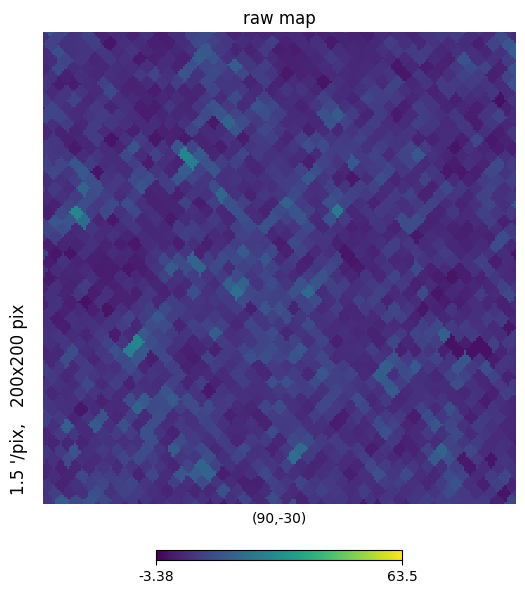

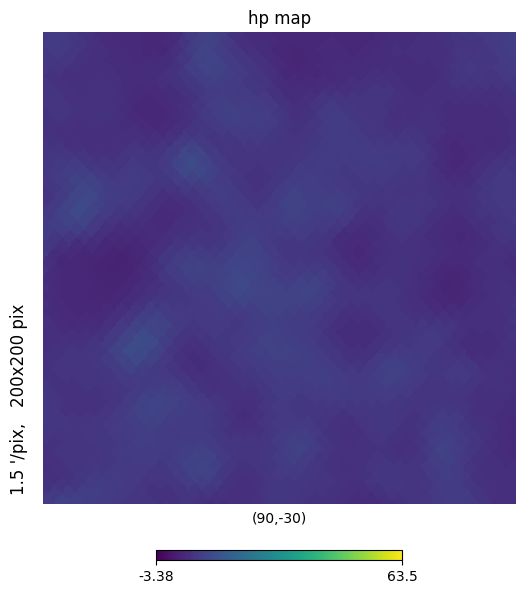

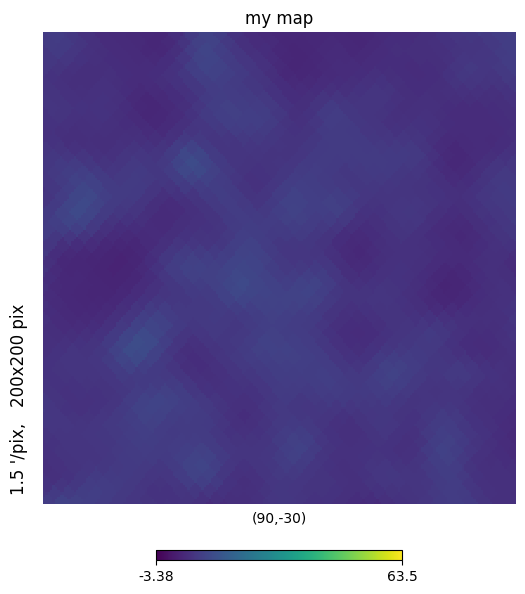

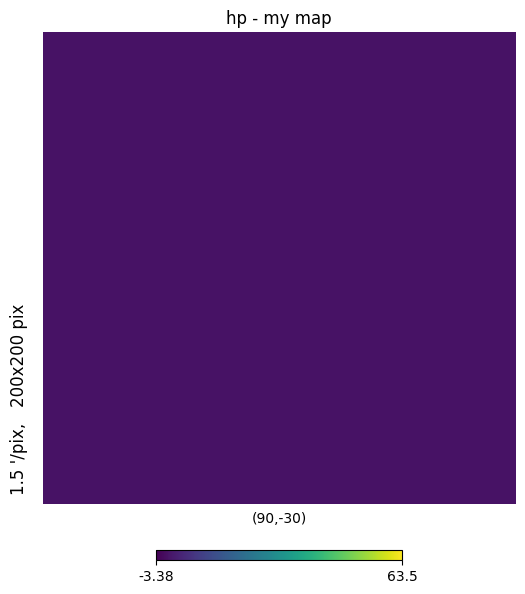

In [5]:
l_max = 500
fwhm = scales.ell_to_angle(l_max, arcmin=False)

vmin, vmax = raw_map.min(), raw_map.max()
rot = (90, -30, 0)

# hp.mollview(raw_map, title="raw map", nest=True, min=vmin, max=vmax)
hp.gnomview(raw_map, title="raw map", nest=True, min=vmin, max=vmax, rot=rot)

hp_map = hp.smoothing(raw_map, fwhm=fwhm, nest=True)
# hp.mollview(hp_map, title="hp map", nest=True, min=vmin, max=vmax)
hp.gnomview(hp_map, title="hp map", nest=True, min=vmin, max=vmax, rot=rot)

my_map, _ = scales.map_to_smoothed_map(raw_map, n_side=n_side, theta_fwhm=fwhm, nest=True, arcmin=False)#, l_max=500)
# hp.mollview(my_map, title="my map", nest=True, min=vmin, max=vmax)
hp.gnomview(my_map, title="my map", nest=True, min=vmin, max=vmax, rot=rot)

# hp.mollview(hp_map - my_map, title="hp - my map", nest=True, min=vmin, max=vmax)
hp.gnomview(hp_map - my_map, title="hp - my map", nest=True, min=vmin, max=vmax, rot=rot)

# remove big scales / high pass filter

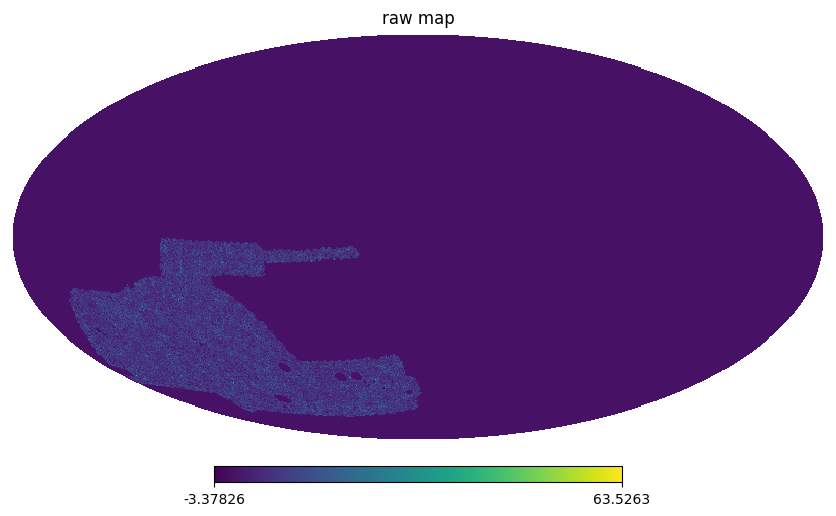

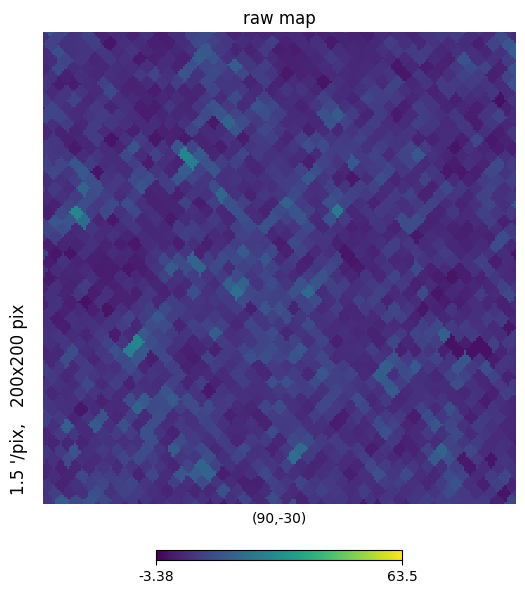

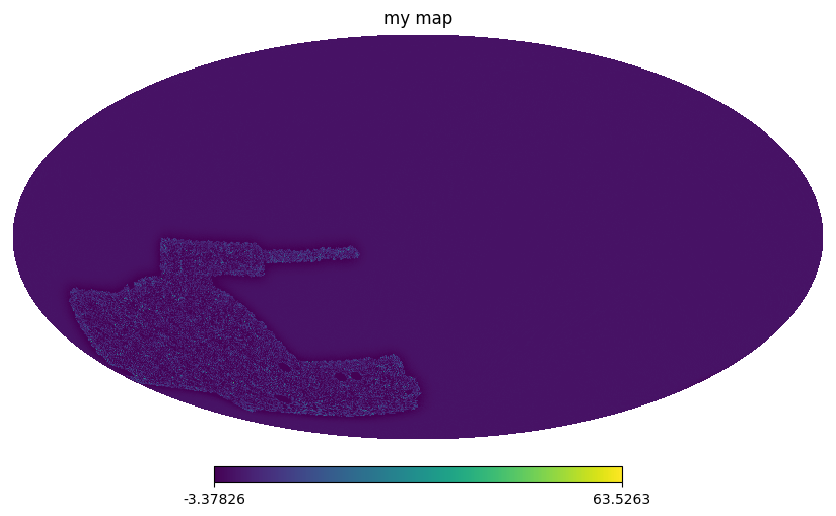

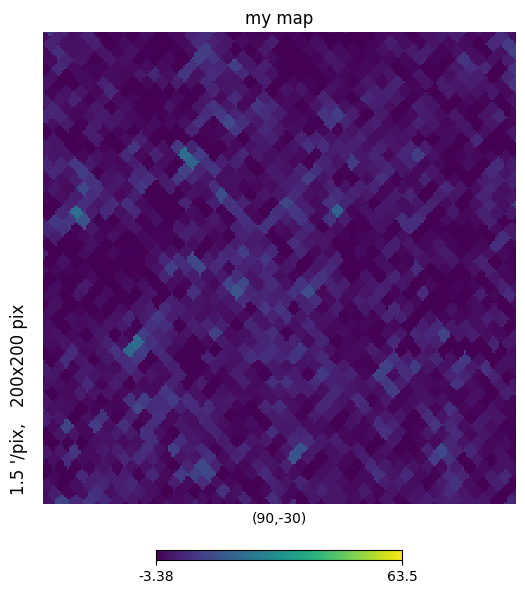

In [6]:
l_min = 30

vmin, vmax = raw_map.min(), raw_map.max()
rot = (90, -30, 0)

hp.mollview(raw_map, title="raw map", nest=True, min=vmin, max=vmax)
hp.gnomview(raw_map, title="raw map", nest=True, min=vmin, max=vmax, rot=rot)

my_map, _ = scales.map_to_smoothed_map(raw_map, n_side=n_side, l_min=l_min, nest=True)
hp.mollview(my_map, title="my map", nest=True, min=vmin, max=vmax)
hp.gnomview(my_map, title="my map", nest=True, min=vmin, max=vmax, rot=rot)

# do nothing

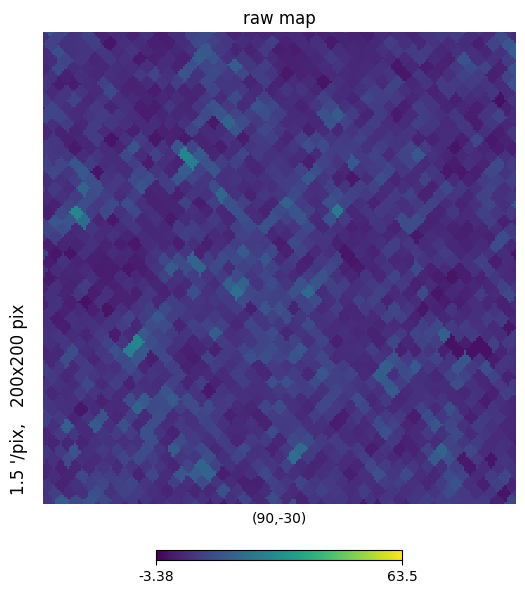

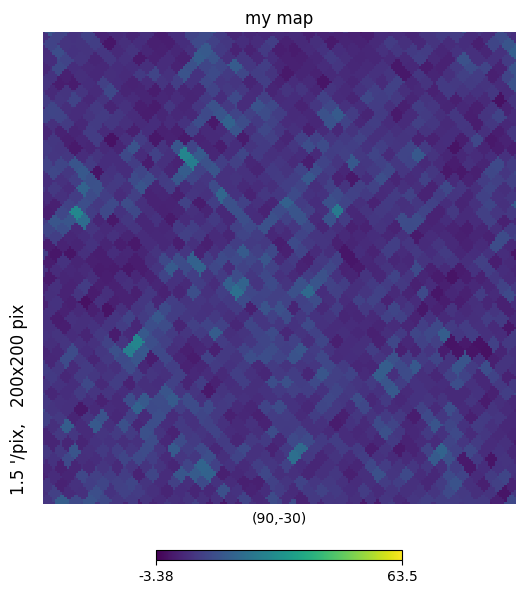

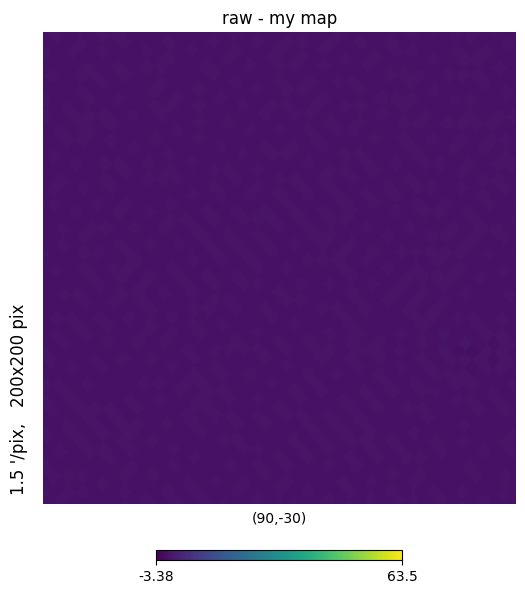

In [7]:
l_min = None
l_max = None
theta_fwhm = None

vmin, vmax = raw_map.min(), raw_map.max()
rot = (90, -30, 0)

# hp.mollview(raw_map, title="raw map", nest=True, min=vmin, max=vmax)
hp.gnomview(raw_map, title="raw map", nest=True, min=vmin, max=vmax, rot=rot)

my_map, _ = scales.map_to_smoothed_map(raw_map, n_side=n_side, l_min=l_min, l_max=l_max, theta_fwhm=theta_fwhm, nest=True)
# hp.mollview(my_map, title="my map", nest=True, min=vmin, max=vmax)
hp.gnomview(my_map, title="my map", nest=True, min=vmin, max=vmax, rot=rot)

hp.gnomview(raw_map - my_map, title="raw - my map", nest=True, min=vmin, max=vmax, rot=rot)